# SYDE 552 Assignment 2: Vision
### Due Monday, February 19, 11:59pm
### Value: 15% of total marks for the course

This assignment covers the mammilian vision system, including both questions about the biology itself and constructing computational models based on Regression and Convolutional Neural Networks.

You can work in groups to do the assignment, but your answers and code must be original to you. Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

# 1. The Vision System

The purpose of this part of the assignment is to test your knowledge of the brain’s visual system and the relationship between neurobiological features and computational properties. The best answers will discuss both function and anatomy, and will draw on specific anatomical examples to support theoretical claims. You are encouraged to discuss answers with your classmates, consult the slides notes, or use external resources -- but your answers must be your own! In particular, read the Kandel et al. chapters listed on the slides. Expect to write around 5 sentences for each 1 point.

**1.a) [2 marks]** The neurons in different parts of the brain are sensitive to different things, and can be thought of as different feature detectors.  For each of the types of neurons listed below, describe what feature they detect, their receptive fields, and how their connectivity to other neurons and/or their internal neural processes helps them to do this feature detection:
- Cones
Cones are photosensitive neurons that are sensitive to brightness. These neurons provide a intensity signal sensitive to different light wavelengths which allows for colour vision. Cones have a small receptive field (sensitive to specific wavelengths) and densely populate the retina. These cells are connected to an additional ~3 layers of neurons in the Retina that then transform the signal to adjust for factors such as brightness and lateral inhibition.

- Sustained Ganglion Cells
Sustained ganglion cells are sensitive to stationary features such as edges and contours. The receptive field is still small, but larger than cones (able to detect high frequency spatial data such as edges). They receive signal from cones (colour intensity signal) and can act as a edge enhancer through by responding to the excitation of neighbouring cells (lateral inhibition).

- Transient Ganglion Cells
Transient Ganglion Cells are sensitive to motion, or change in visual signal. These have a larger receptive field compared to sustained ganglion cells so they respond to lower frequency spatial information. These also receive input from cones (via bipolar) but are unique in their response to temporal change. They are able to quickly reset (transient period) and react to changes in spatial information.

- Simple Cells
Simple cells are found further along the signal processing journey, in the visual cortex. These cells are sensitive to orientation (i.e. a line in a specific orientation). They have a large receptive field that is specific to an orientation. These cells receive a signal from the ganglion cells (via. LGN relay neurons). These signals have gone through a few layers of transformations, so the signal has been adjusted to highlight edges and motion in some cases. The signal is then passed to a complex cell.


**1. b) [1 marks]** Describe two instances where retinotopic organization facilitates visual processing.  For each example, be sure to mention its anatomical location and discuss how retinitopy contributes to the feature detection.

Retinotopic organization refers to how neurons that have similar receptive fields and are neighbours in the retina will have related cells that are close together in the cortex.
One example is the primary visual cortext (V1, Occipital lobe in the rear of brain). This area is vaguely responsible for detecting basics such as orientation and motion of objects. The retinatopic organization of cells preserves much of the spatial information that is gathered by cells in the retina. This ensures that spatial accuracy is maintained and features such as orientation and motion direction can be detected.
Another example is in the V4 visual area (occipitotemporal cortex). This area is associated with object recognition and colour identification Retinitopic organization ensures that spatial detail is included in the signal (from V1). This means that object-specific features (such as colour patterns) remain in a specific spatial location, aiding in object identification.

**1. c) [2 marks]** Discuss the similarities and differences between convolutional neural networks and the visual system.

Convolutional neural networks are a decent representation of signal processing in the visual system. Both processes are layered in a hierchical manner. Both have local receptive fields and are translationally invariant. Further, both backprop-trained CNNs and the visual system learn features from experience.
With that said, convolutional neural networks have some clear differences. Firstly, the biological vision system cannot 'share weights'. It also does not have a regular 'grid' pattern like convolution. Further, biology has special neuron adaptation that may change the response depending on preceding stimulations. Lateral connections are typical in BNN and not in CNNs. Finally, we don't really know if the concept of 'backprogogation' is possible in the brain. It is not clear how (or if) error information is sent back to earlier processing layers. Backpropogation in CNNs are simply the solution that we have created to 'learn' and adjust weights. Note that human biology is a lot more efficient than the artificial processing!

# 2. Classifying Stimuli Using Regression

The retina transforms the light entering an eye into a particular set of features, which are then sent to the rest of the brain for further processing.  In this section we look at how neurons might detect patterns, and how that detection changes with different feature detectors.

The data we will use for this is the classic MNIST dataset 

In [1]:
import torchvision
mnist = torchvision.datasets.MNIST(root='.', download=True)

The MNIST digits are 28x28 pixels each, each pixel is a value from 0 to 255, and there are 60,000 of them.  The raw data is in `mnist.data` and the target value (i.e. the actual digit) is in `mnist.targets`.  Here are the first 24 of each:

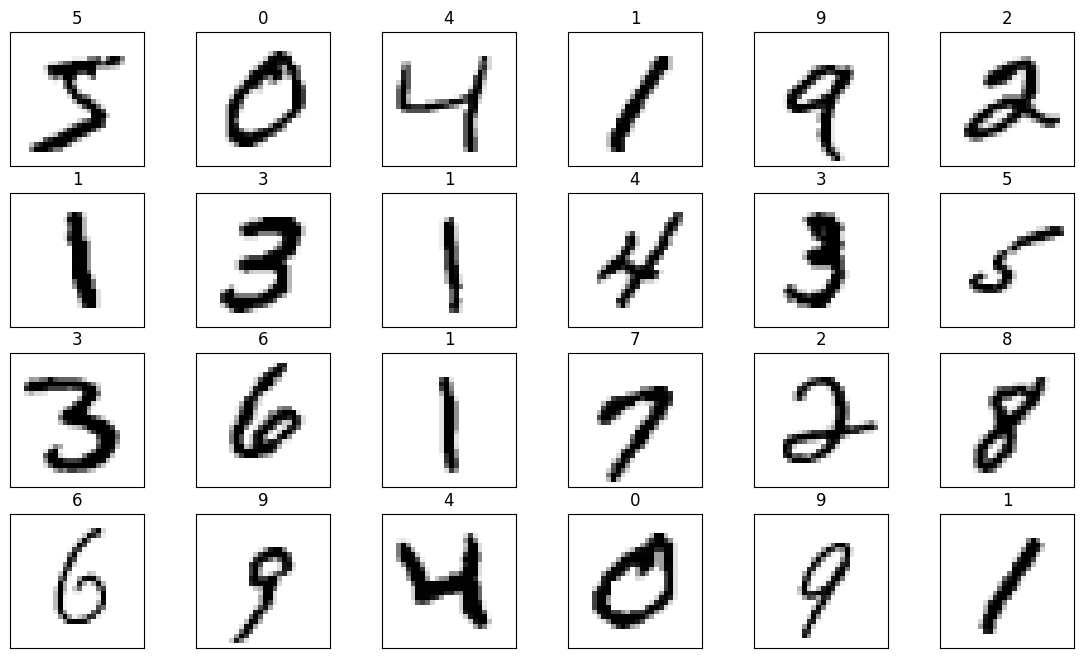

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(mnist.data[i], vmin=0, vmax=255, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(mnist.targets[i]))

**2.a) [1 mark]** We can imagine the MNIST digits as 784 (28 times 28) input neurons.  We want to connect these 784 neurons to 10 output neurons, one for each digit, and see how accurately we can classify the digits.  

To find the weights in this question, we will use Ridge Regression.  `X` is the MNIST input data, divided by 255 to rescale it to between 0 and 1, and then reshaped to be a 60000x784 matrix

```
X = mnist.data.reshape((60000,28*28)).float()/255
```

The target data T is a "one-hot" representation of our outputs.  That is, instead of the desired output to be `5`, the output should be `[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]` and if the desired output should be `0`, that would be `[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]`.  

```
T = torch.nn.functional.one_hot(mnist.targets).float()
```

If our output is `Y=X @ W`, we need to find `W` such that `Y` is as close as possible to `T`.  For Ridge Regression, this is computed as

```
W = torch.inverse(X.T @ X + lambd*I) @ (X.T @ T)
```

where `I` is an identity matrix of the correct size (`torch.eye(784).float()`) and `lambd` is the $\lambda$ parameter that stops the regression from overfitting.

When building any sort of classifier model, we generally want to create the model using one set of data, and then test it on another set of data.  Here, we will use the first 5,000 data points for creating ("training") the model, and the other 55,000 for testing:

```
N = 5000
X_train, X_test = X[:N], X[N:]  # split X into two parts for training and testing
T_train, T_test = T[:N], T[N:]  # split T into two parts for training and testing
```

Given this data, you should find `W` using *only* the `X_train` and `T_train` data.  Once you find `W` you can apply it to the `X_train` and `X_test` to get `Y_train` and `Y_test`

```
Y_train = X_train @ W
Y_test = X_test @ W
```

Finally, you can compute the accuracy by determining when the output is the correct category.  Here we will do this by counting when the largest output value in each row in `Y` is at the same spot as the largest output value in each row in `T`:

```
accuracy_train = torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train)
accuracy_test = torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test)
```

- Compute the training and testing accuracy when $\lambda=1$ and we use the first 5,000 data points as for training (and test on the remaining 55,000).  Report both numbers.  
- Do we expect the testing accuracy to be larger or smaller than the training accuracy?  Why?

The training accuracy is expected to be consistently greater than the testing accuracy. Since the model is trained on the training data, when it is asked to predict output for training data, it has already 'seen' this data. The model is essentially 'tuned' for the training data, so it is expected that the accuracy will be high. In contrast, testing data is information that is brand new to the model. If the data is of good quality and is adaquetly partitioned, the accuracy should see a small drop. This is essentially a true test of the model's ability to generalize output based on input (training) data that it has seen. This also depends on the model itself. Certain parameters may result in 'overfitting', meaning the model is highly specialized for the training data and is unable to generalize well. This would result in a large discrepancy between training and testing accuracy.


In [3]:
import torch

X = mnist.data.reshape((60000,28*28)).float()/255

T = torch.nn.functional.one_hot(mnist.targets).float()

lambd = 1 
I = torch.eye(784).float()
W = torch.inverse(X.T @ X + lambd*I) @ (X.T @ T) # @ is the matrix multiplication operator in PyTorch

N = 5000 # number of data points to use for training
X_train, X_test = X[:N], X[N:]  # split X into two parts
T_train, T_test = T[:N], T[N:]  # split T into two parts

# Given this data, you should find `W` using *only* the `X_train` and `T_train` data.  Once you find `W` you can apply it to the `X_train` and `X_test` to get `Y_train` and `Y_test`
Y_train = X_train @ W # @W means that we are multiplying each row of `X_train` and `X_test` by `W`.
Y_test = X_test @ W

# compute accuracy
accuracy_train = torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train)
accuracy_test = torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test)

print(f'Accuracy on training data: {accuracy_train:.3f}')
print(f'Accuracy on testing data: {accuracy_test:.3f}')

Accuracy on training data: 0.863
Accuracy on testing data: 0.851


**2. b) [2 marks]**  Repeat part a) but vary the value of `lambd` from $10^{-5}$ to $10^5$.   You can use a `for` loop such as `for lambd in np.logspace(-5, 5, 11):`.  

- Generate a single plot that shows the training and testing accuracy.  Make sure to label your axes and the lines on the plot.  

- What is the best value for `lambd` (i.e. the value for which we get the best training accuracy). 
Results from the plot show that a value between 10^-4 and 1 provides the best results for training accuracy. 

- Why does changing `lambd` affect the accuracy?  
Notice that the best lambda value for testing accuracy is slightly higher, at around 10^2. This may be due to the fact that a higher lambda value penalizes large weights in the model. This can help prevent overfitting. This is evident in the plot, where a small lambda results in excellent training accuracy (overfit), but a slightly larger lambda is able to generalize to testing data better.

- Why would having a large `lambd` value be good for making a biologically realistic model?
Biological systems are very good at generalizing (far better than artificial models). Increasing lambda can help an ANN improve its ability to generalize by avoiding overfitting and increasing the ability to handle noise. Further, biological systems are very energy efficient. Large lamba values means that the weight matrices are more evenly distributed which may result in a more efficient model (still nothing close to biological).

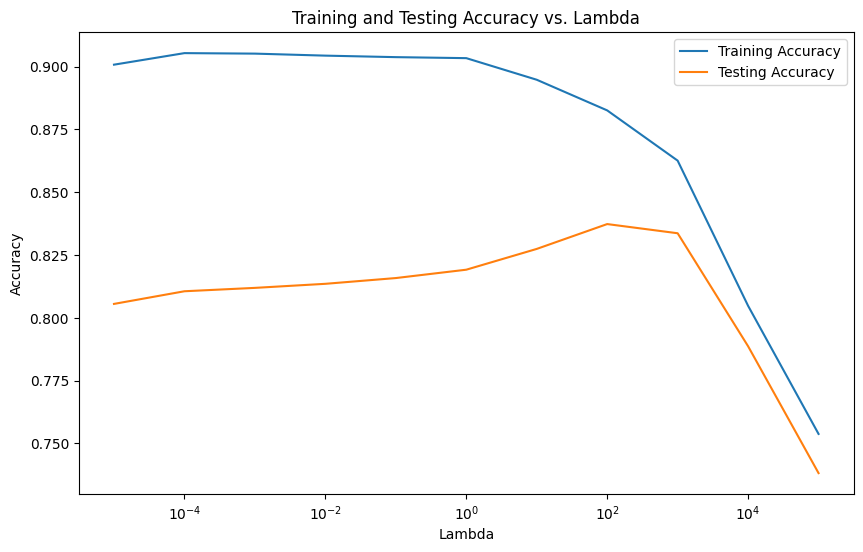

In [4]:
# **2. b) [2 marks]**  Repeat part a) but vary the value of `lambd` from $10^{-5}$ to $10^5$.   You can use a `for` loop such as `for lambd in np.logspace(-5, 5, 11):`.  Then, Generate a single plot that shows the training and testing accuracy.  Make sure to label your axes and the lines on the plot.  

import numpy as np

training_accuracies = []
testing_accuracies = []

for lambd in np.logspace(-5, 5, 11):
    W = torch.inverse(X_train.T @ X_train + lambd*I) @ (X_train.T @ T_train)
    Y_train = X_train @ W
    Y_test = X_test @ W
    accuracy_train = torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train)
    accuracy_test = torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test)
    training_accuracies.append(accuracy_train)
    testing_accuracies.append(accuracy_test)
    # print(f'Lambda: {lambd:.0e} | Accuracy on training data: {accuracy_train:.3f} | Accuracy on testing data: {accuracy_test:.3f}')

# plot
plt.figure(figsize=(10,6))
plt.plot(np.logspace(-5, 5, 11), training_accuracies, label='Training Accuracy')
plt.plot(np.logspace(-5, 5, 11), testing_accuracies, label='Testing Accuracy')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy vs. Lambda')
plt.legend()
plt.show()

**2. c) [1 mark]** The input we have used so far is not very realistic.  In real life, when we see written digits, they are under a wide range of lighting conditions. For this question, we change `X` by scaling it randomly and adding a random background brightness.

```
X = mnist.data.reshape((60000,28*28)).float()/255
X = X*(1-2*torch.rand(60000)[:,None]) + torch.rand(60000)[:,None]
```

To see what this looks like, here is how you can plot it:

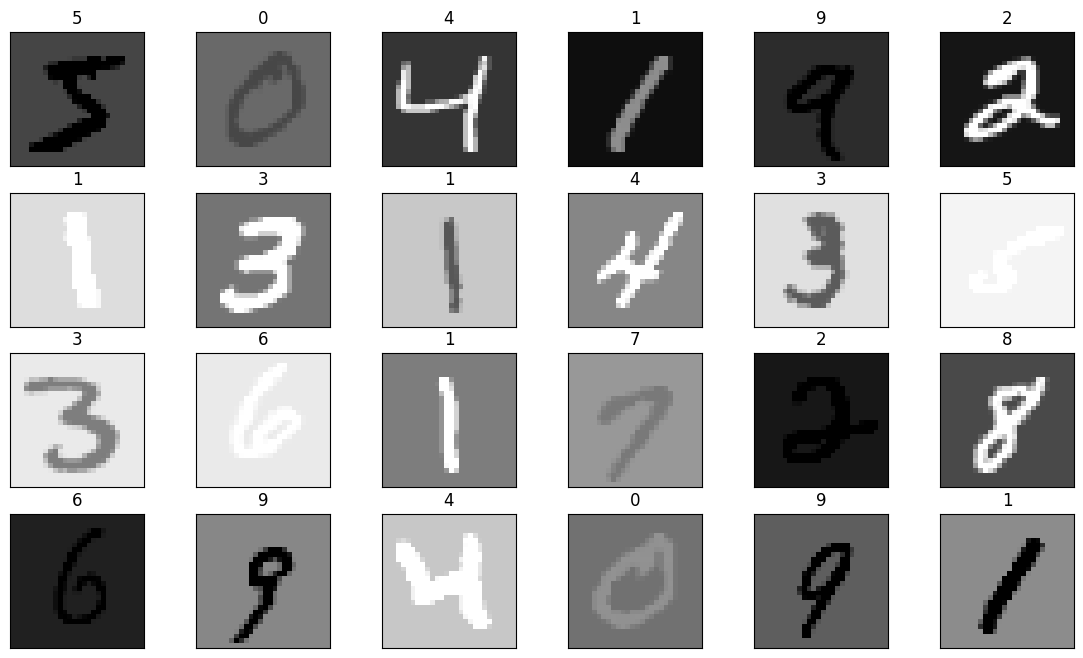

In [5]:
# **2. c) [1 mark]** The input we have used so far is not very realistic.  In real life, when we see written digits, they are under a wide range of lighting conditions. For this question, we change `X` by scaling it randomly and adding a random background brightness.

X = mnist.data.reshape((60000,28*28)).float()/255
X = X*(1-2*torch.rand(60000))[:,None] + torch.rand(60000)[:,None]

plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(X[i].reshape(28,28), vmin=0, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(mnist.targets[i]))


- Generate the same plot as in 2b) but for this new dataset.  
- Is this a harder or easier task than with the original dataset?

This task is harder than the task in 2b. The new dataset introduces more variation. This means that the model must learn and generalize from a wider range of inputs. Further, features such as edges may be harder to identify given a smaller intensity gradient between the background and the number.

- Is this new dataset more like the data at the retina or like the data in the ganglion cells?

This new dataset is more like the data at the retina. In the real world, the retina is exposed to a variety of brightness levels.

- Is the original dataset more like the data at the retina or like the data in the ganglion cells?

The original dataset is (slightly) more like the data in the ganglion cells. The signal goes through a number of layers of processing in the retina (bipolar, horizontal cells, etc.) that adjusts for factors such as brightness. However, the original dataset is still a gross exaggeration. The ganglion cells will still have variation in brightness.

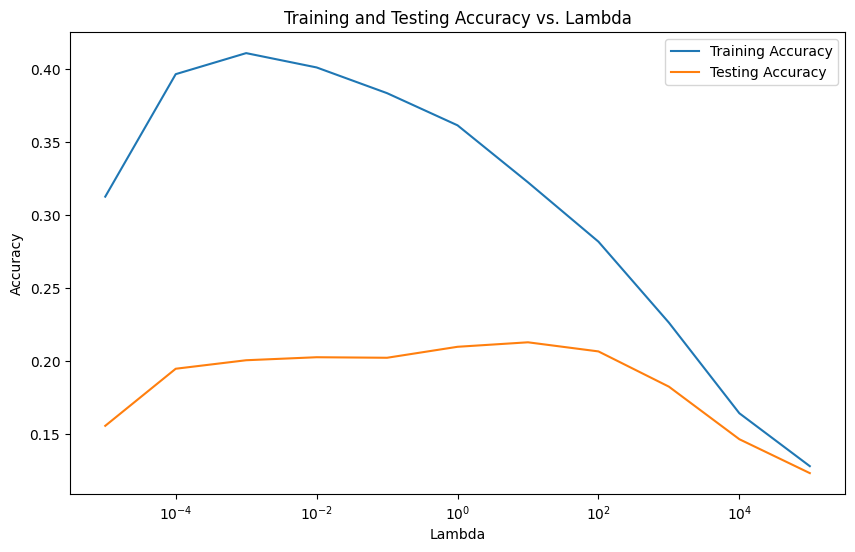

In [23]:
# Generate the same plot as in 2b) but for this new dataset.  

X = mnist.data.reshape((60000,28*28)).float()/255
X = X*(1-2*torch.rand(60000))[:,None] + torch.rand(60000)[:,None]
T = torch.nn.functional.one_hot(mnist.targets).float()

N = 5000 # number of data points to use for training

X_train, X_test = X[:N], X[N:]  # split X into two parts for training and testing
T_train, T_test = T[:N], T[N:]  # split T into two parts for training and testing

training_accuracies = []
testing_accuracies = []

# go from 10 ^ -2 to be able to invert
for lambd in np.logspace(-2, 5, 11):
    W = torch.inverse(X_train.T @ X_train + lambd*I) @ (X_train.T @ T_train) 
    Y_train = X_train @ W
    Y_test = X_test @ W
    accuracy_train = torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train)
    accuracy_test = torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test)
    training_accuracies.append(accuracy_train)
    testing_accuracies.append(accuracy_test)
    # print(f'Lambda: {lambd:.0e} | Accuracy on training data: {accuracy_train:.3f} | Accuracy on testing data: {accuracy_test:.3f}')

# plot
plt.figure(figsize=(10,6))
plt.plot(np.logspace(-5, 5, 11), training_accuracies, label='Training Accuracy')
plt.plot(np.logspace(-5, 5, 11), testing_accuracies, label='Testing Accuracy')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy vs. Lambda')
plt.legend()
plt.show()

    

**2. d) [1 mark]** We can think of neurons in the visual system as transforming the data in various ways.  Given the dataset in 2c), neurons might be able to transform it to look more like the origin data.

Here are three data transformations that could be applied here:

Subtracting the Mean
```
X = X-torch.mean(X, axis=1)[:,None]
```

Absolute value
```
X = torch.abs(X)
```

Normalizing
```
X = X/torch.linalg.norm(X, axis=1)[:,None]
```

- Apply all three of them (in the order shown above) to the dataset and generate the same graph as in 2b) and 2c).
- How does the performance of the network compare to that of 2b) and 2c)?

The performance of the network after the 3 transformations results in significantly better accuracy (for both testing and training). Testing accuracy with no transformation peaks at just over 20%, wheras it peaks at just under 85% using the transformed images.

- Do any of the three transformations above correspond to processing that occurs in the eye before the signal is sent to the rest of the brain?

Yes. The first tranformation (subtracting the mean) is a form of centering the range of values around 0. This corresponds to the process in which cells sum (integrate) the signal with neighbouring cells. While not exactly the same as subtracting the mean, both processes act as a way to enhance the contrast level. Absolute value is a way of ensuring that the values remain positive and is not necessarily a replica of biological processing. While mathematical normalization does not occur in the retina, it represents how a neuron firing can be adjusted based on the overall activity in the area. This can maintain a even sensitivity in a wide range of intensity levels (i.e. at dusk vs. at noon).

- Given this result, why does the eye transform the data between raw rods & cones and the ganglion cells?

The results show that transformations can play a significant role in the performance of a vision model (including our biological system). In real life, the signal that our cones and rods receive vary in intensity and signal quality (time of day, glasses vs. no glasses, etc.). The transformations from the raw signal to processing ensures that the signal sent to the ganglion is useful. In the cases described above, these transformations can evenly distribute the brightness to adapt to various conditions, enhance the signal quality (such as edges), and reduce noise.


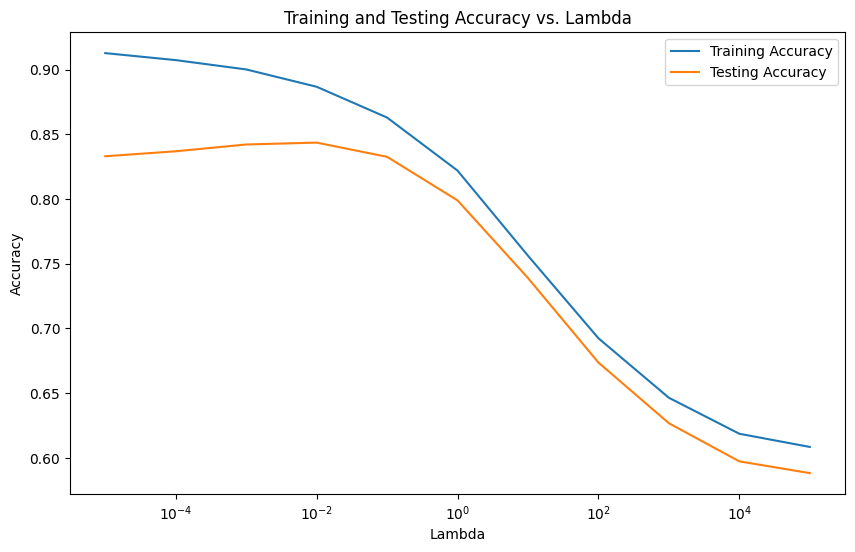

In [24]:
# **2. d) 

# Generate the same plot as in 2b) but for this new dataset.  

X = mnist.data.reshape((60000,28*28)).float()/255
X = X*(1-2*torch.rand(60000))[:,None] + torch.rand(60000)[:,None]

# Subtracting the Mean
X = X-torch.mean(X, axis=1)[:,None]
# Absolute value
X = torch.abs(X)
# Normalizing
X = X/torch.linalg.norm(X, axis=1)[:,None]

T = torch.nn.functional.one_hot(mnist.targets).float()

N = 5000 # number of data points to use for training

X_train, X_test = X[:N], X[N:]  # split X into two parts for training and testing
T_train, T_test = T[:N], T[N:]  # split T into two parts for training and testing

training_accuracies = []
testing_accuracies = []

# go from 10 ^ -2 to be able to invert
for lambd in np.logspace(-2, 5, 11):
    W = torch.inverse(X_train.T @ X_train + lambd*I) @ (X_train.T @ T_train) 
    Y_train = X_train @ W
    Y_test = X_test @ W
    accuracy_train = torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train)
    accuracy_test = torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test)
    training_accuracies.append(accuracy_train)
    testing_accuracies.append(accuracy_test)
    # print(f'Lambda: {lambd:.0e} | Accuracy on training data: {accuracy_train:.3f} | Accuracy on testing data: {accuracy_test:.3f}')

# plot
plt.figure(figsize=(10,6))
plt.plot(np.logspace(-5, 5, 11), training_accuracies, label='Training Accuracy')
plt.plot(np.logspace(-5, 5, 11), testing_accuracies, label='Testing Accuracy')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy vs. Lambda')
plt.legend()
plt.show()


# 3. Classifying Stimuli Using Backpropogation

Regression is restricted to learning the layer of weights that produces the final output.  If we want to also learn what features are most useful for producing that output, we need a more complex learning rule, and this is typically backpropogation.  Here we will classify the same data as in question 2, and we will build up different network structures to do so.

Backpropogation tends to work best when learning on a bunch of data at the same time (a "batch").  The following code will set up the same training and testing data as in question 2, but presented in randomized batches of 1000 at a time.

```python
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)), 
                                           batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)), 
                                          batch_size=1000, shuffle=True)
```

To create a neural network, we need to define what the weights are we will learn and we need to define the computation that the network will perform.  Here is the definition of a simple network that has an input of 784 values (the MNIST inputs), which go to 50 "hidden"-layer neurons, and then to the output 10 neurons.  So the network will learn to transform the 784 inputs into 50 new representations, and from those 50 features it will learn weights to create an output of 10 values (our 10 categories).  This is known as a multi-layer perceptron, or a standard neural network with a single hidden layer.

```python
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # these will be learned
        self.fc1 = nn.Linear(784, 50)   # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(50, 10)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = x.view(-1, 784)             # flatten the input from 28x28 to 784 values
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category
    
network = Net()
```

Finally, we need to train our model.  When training, it is useful to keep track of how well the model is doing on the testing data.  Since testing the network takes time, we don't necessarily want to do it all the time.  Instead, the following code trains the network 10 times, and then records how well the network does on the training data and on the testing data.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # these will be learned
        self.fc1 = nn.Linear(784, 50)   # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(50, 10)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = x.view(-1, 784)             # flatten the input from 28x28 to 784 values
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category
    
network = Net()

In [9]:
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)), 
                                           batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)), 
                                          batch_size=1000, shuffle=True)

In [10]:
import torch.optim as optim

# create the learning rule
optimizer = optim.SGD(network.parameters(), 
                      lr=0.1,   # learning rate
                      momentum=0.5)

# variables to keep track of the training and testing accuracy
accuracy_train = []
accuracy_test = []

def continue_training():
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        correct = 0
        for data, target in train_loader:       # working in batchs of 1000
            optimizer.zero_grad()               # initialize the learning system
            output = network(data)              # feed in the data 
            loss = F.nll_loss(output, target)   # compute how wrong the output is
            loss.backward()                     # change the weights to reduce error
            optimizer.step()                    # update the learning rule
            
            pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
            correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of training accuracy values
    score = float(correct/len(train_loader.dataset))
    accuracy_train.append(score)
    print('Iteration', len(accuracy_train), 'Training accuracy:', score)
    
    correct = 0
    network.eval()
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
        correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of testing accuracy values
    score = float(correct/len(test_loader.dataset))
    accuracy_test.append(score)
    print('Iteration', len(accuracy_test), 'Testing accuracy:', score)


Given the above code, you can train your network 10 times by doing

```python
for i in range(10):
    continue_training()
```

If you want to continue training even more, you can just run that `for` loop again.

To plot the final accuracy results, you can use

```python
plt.figure(figsize=(12,4))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()
```

**3. a) [1 mark]** Run the model above for 10 iterations (i.e. call `continue_training` 10 times).

- Plot the training and testing accuracy.  
- Is this model better or worse than the best models developed in question 2?

This model performs better than the best models in question 2. Here, the testing accuracy reaches above 90%, wheras in question 2 the highest accuracy was 85%. This shows the importance of weight selection. Running the model 10 times allows for the weights to update recursively based on the previous performance.

/var/folders/j4/lhlw9vy94dj320jbdphcvs100000gq/T/ipykernel_30445/1004733722.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category


Iteration 1 Training accuracy: 0.8578000068664551
Iteration 1 Testing accuracy: 0.8510000109672546
Iteration 2 Training accuracy: 0.9003999829292297
Iteration 2 Testing accuracy: 0.8823999762535095
Iteration 3 Training accuracy: 0.9142000079154968
Iteration 3 Testing accuracy: 0.892799973487854
Iteration 4 Training accuracy: 0.9261999726295471
Iteration 4 Testing accuracy: 0.8981999754905701
Iteration 5 Training accuracy: 0.9327999949455261
Iteration 5 Testing accuracy: 0.9028000235557556
Iteration 6 Training accuracy: 0.9368000030517578
Iteration 6 Testing accuracy: 0.902999997138977
Iteration 7 Training accuracy: 0.9423999786376953
Iteration 7 Testing accuracy: 0.9075999855995178
Iteration 8 Training accuracy: 0.9449999928474426
Iteration 8 Testing accuracy: 0.9075999855995178
Iteration 9 Training accuracy: 0.9506000280380249
Iteration 9 Testing accuracy: 0.9093999862670898
Iteration 10 Training accuracy: 0.9527999758720398
Iteration 10 Testing accuracy: 0.9082000255584717


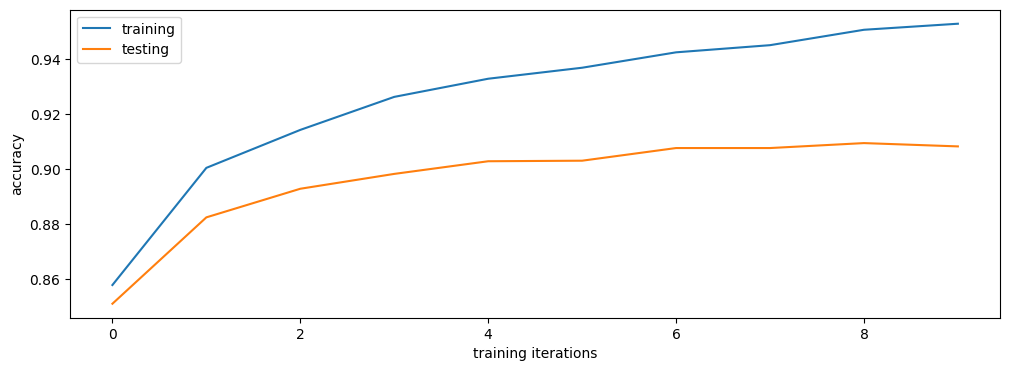

In [11]:
# **3. a) [1 mark]** Run the model above for 10 iterations (i.e. call `continue_training` 10 times).

# - Plot the training and testing accuracy.  

for i in range(10):
    continue_training()

# plot
plt.figure(figsize=(12,4))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()

**3. b) [1 mark]** Repeat question 3a five times.  This does not mean to run a single model for 50 iterations.  Rather, you need to reset the model and train it again.  The easiest way to do this is to recreate the network and the optimizer like this:

```python
network = Net()
optimizer = optim.SGD(network.parameters(), 
                      lr=0.1,
                      momentum=0.5)
```

- Make a plot showing the 5 different training accuracies and 5 different testing accuracies
- Also show the average training and testing accuracy on the plot.
- Each of the 5 models should show slightly different accuracies.  Why is this the case?

The 5 models are expected to show slightly different accuracies. Firstly, the initial weights are set randomely using PyTorch. Further, the data is sampled at 1000 batches at random. This means that the result is not deterministic by nature.



/var/folders/j4/lhlw9vy94dj320jbdphcvs100000gq/T/ipykernel_30445/1004733722.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category


Iteration 1 Training accuracy: 0.8637999892234802
Iteration 1 Testing accuracy: 0.8586000204086304
Iteration 2 Training accuracy: 0.9028000235557556
Iteration 2 Testing accuracy: 0.8884000182151794
Iteration 3 Training accuracy: 0.9138000011444092
Iteration 3 Testing accuracy: 0.8952000141143799
Iteration 4 Training accuracy: 0.9246000051498413
Iteration 4 Testing accuracy: 0.9017999768257141
Iteration 5 Training accuracy: 0.932200014591217
Iteration 5 Testing accuracy: 0.906000018119812
Iteration 6 Training accuracy: 0.9363999962806702
Iteration 6 Testing accuracy: 0.9074000120162964
Iteration 7 Training accuracy: 0.9431999921798706
Iteration 7 Testing accuracy: 0.9093999862670898
Iteration 8 Training accuracy: 0.9466000199317932
Iteration 8 Testing accuracy: 0.9100000262260437
Iteration 9 Training accuracy: 0.9491999745368958
Iteration 9 Testing accuracy: 0.9100000262260437
Iteration 10 Training accuracy: 0.9521999955177307
Iteration 10 Testing accuracy: 0.9107999801635742
Iteration 

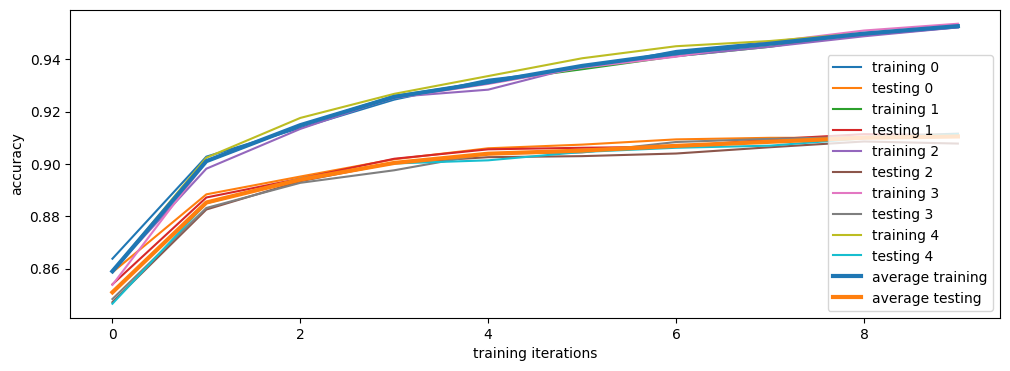

In [12]:
# **3. b) [1 mark]** Repeat question 3a five times.  This does not mean to run a single model for 50 iterations.  Rather, you need to reset the model and train it again.  The easiest way to do this is to recreate the network and the optimizer like this:

# - Make a plot showing the 5 different training accuracies and 5 different testing accuracies
# - Also show the average training and testing accuracy on the plot.

# make 2d array to store the results for the 5 runs
training_accuracies_matrix = np.zeros((5, 10))
testing_accuracies_matrix = np.zeros((5, 10))

for i in range(5):
    network = Net()
    optimizer = optim.SGD(network.parameters(), 
                          lr=0.1,
                          momentum=0.5)
    accuracy_train = []
    accuracy_test = []
    for j in range(10):
        continue_training()
    training_accuracies_matrix[i] = accuracy_train
    testing_accuracies_matrix[i] = accuracy_test

# plot
plt.figure(figsize=(12,4))
for i in range(5):
    plt.plot(training_accuracies_matrix[i], label=f'training {i}')
    plt.plot(testing_accuracies_matrix[i], label=f'testing {i}')
plt.plot(np.mean(training_accuracies_matrix, axis=0), label='average training', linewidth=3)
plt.plot(np.mean(testing_accuracies_matrix, axis=0), label='average testing', linewidth=3)
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()



**3. c) [1 mark]** Repeat question 3b varying the number of neurons in the hidden layer of the network.  The current value is 50.  Try it with 5, 10, 20, 50, and 100 neurons.  For each number of neurons, repeat five times and take the average (like in question 3b).  

- Plot the final testing accuracy on the y-axis and the number of neurons on the x-axis.  Note that to speed things up you can remove the testing computation from continue_training until the very end, since we only need the final testing score.


/var/folders/j4/lhlw9vy94dj320jbdphcvs100000gq/T/ipykernel_30445/1004733722.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category


Iteration 1 Training accuracy: 0.7369999885559082
Iteration 1 Testing accuracy: 0.730400025844574
Iteration 2 Training accuracy: 0.8180000185966492
Iteration 2 Testing accuracy: 0.7965999841690063
Iteration 3 Training accuracy: 0.8507999777793884
Iteration 3 Testing accuracy: 0.8198000192642212
Iteration 4 Training accuracy: 0.8633999824523926
Iteration 4 Testing accuracy: 0.8317999839782715
Iteration 5 Training accuracy: 0.8697999715805054
Iteration 5 Testing accuracy: 0.8370000123977661
Iteration 6 Training accuracy: 0.8772000074386597
Iteration 6 Testing accuracy: 0.8407999873161316
Iteration 7 Training accuracy: 0.8848000168800354
Iteration 7 Testing accuracy: 0.8402000069618225
Iteration 8 Training accuracy: 0.8902000188827515
Iteration 8 Testing accuracy: 0.8456000089645386
Iteration 9 Training accuracy: 0.8934000134468079
Iteration 9 Testing accuracy: 0.848800003528595
Iteration 10 Training accuracy: 0.8984000086784363
Iteration 10 Testing accuracy: 0.8468000292778015
Iteration 

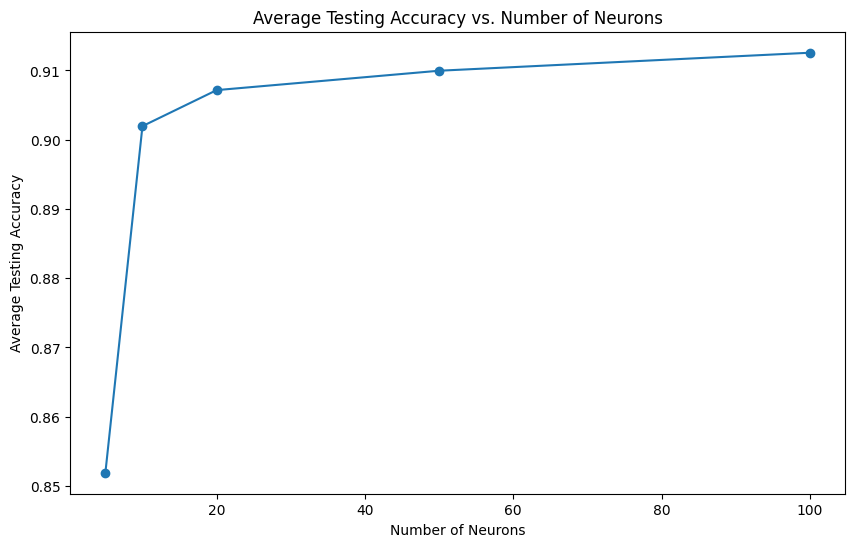

In [17]:
# **3. c) [1 mark]** Repeat question 3b varying the number of neurons in the hidden layer of the network.  The current value is 50.  Try it with 5, 10, 20, 50, and 100 neurons.  For each number of neurons, repeat five times and take the average (like in question 3b).  

# make 2d array to store the results for the 5 runs
testing_accuracies_matrix_2 = np.zeros((5, 5))

for i, neurons in enumerate([5, 10, 20, 50, 100]):
    testing_accuracies = []
    for j in range(5):
        network = Net()
        network.fc1 = nn.Linear(784, neurons)
        network.fc2 = nn.Linear(neurons, 10)
        optimizer = optim.SGD(network.parameters(), 
                              lr=0.1,
                              momentum=0.5)
        accuracy_train = []
        accuracy_test = []
        for k in range(10):
            continue_training()
        testing_accuracies.append(accuracy_test[-1]) # only need the final testing score, last element of the list
    testing_accuracies_matrix_2[:,i] = testing_accuracies # store the results
    
# plot
plt.figure(figsize=(10,6))
plt.plot([5, 10, 20, 50, 100], np.mean(testing_accuracies_matrix_2, axis=0), 'o-')
plt.xlabel('Number of Neurons')
plt.ylabel('Average Testing Accuracy')
plt.title('Average Testing Accuracy vs. Number of Neurons')
plt.show()


**3. d) [2 marks]** Now we will add a convolution layer to our network.  The following network adds two convolution layers before two normal neural network layers.

```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)  # set the size of the convolution to 5x5, and have 12 of them
        self.conv2 = nn.Conv2d(12, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # make sure to do max pooling after the convolution layers
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)
```

The following code can be used to plot the learned features in the first layer:
```python
plt.figure(figsize=(12,5))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(network.conv1.weight[i][0].detach().numpy(), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()
```

- Train the model through 40 iterations and generate a plot of training and testing accuracy over time.
- Does this perform better or worse than the previous models in this assignment?

This performs better than previous models. Allowing for a large number of iterations with a CNN allows for weights to be shared. The local connectivity improves the ability for the model to pick up spatial patterns and relationships between pixels that are important.

- What advantages and disadvantages do you see with this approach (in comparison to the previous parts of the assignment)?
The advantage in the context of image classification usually means higher accuracy for the reasons described above. Another advantage of CNNs is that shared weights means that memory and time efficiency can be improved in comparison to other methods. This can be especially useful for large datasets like images. One disadvantage is that CNNs are more complex and also require large datasets to perform well.

- Plot the features learned by the first convolution layer.  How do they compare to real features detected in the V1 area of the brain?

The V1 part of the brain is associated with recognition of edges and objects in specific orientations. The first features are expected to be kernels that pick up on a variety of frequencies in the spatial domain. In that regard, certain kernels may 'sharpen' edges in certain orientations (see kernel #4 appears to be low intensity on the top right and high intensity on bottom left). It is difficult to fully interpret these kernels with the naked eye. Looking at the Fourier domain might provide additional insight on which frequencies are picked up.

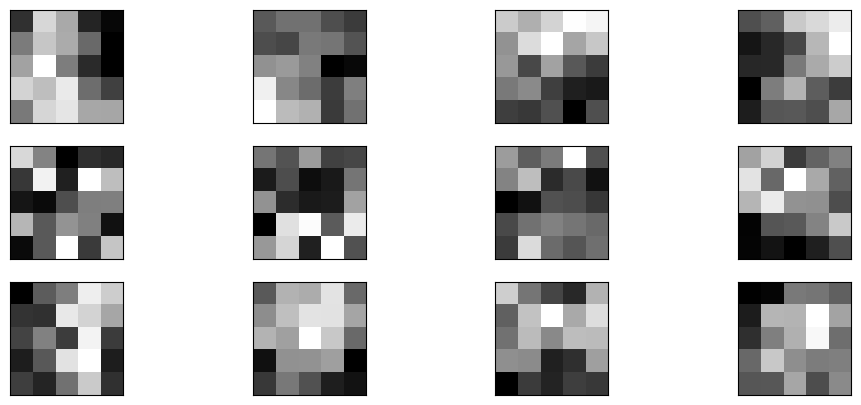

/var/folders/j4/lhlw9vy94dj320jbdphcvs100000gq/T/ipykernel_30445/3740060226.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Iteration 1 Training accuracy: 0.7148000001907349
Iteration 1 Testing accuracy: 0.8022000193595886
Iteration 2 Training accuracy: 0.9308000206947327
Iteration 2 Testing accuracy: 0.9204000234603882
Iteration 3 Training accuracy: 0.9570000171661377
Iteration 3 Testing accuracy: 0.9391999840736389
Iteration 4 Training accuracy: 0.9718000292778015
Iteration 4 Testing accuracy: 0.9527999758720398
Iteration 5 Training accuracy: 0.9805999994277954
Iteration 5 Testing accuracy: 0.9517999887466431
Iteration 6 Training accuracy: 0.9851999878883362
Iteration 6 Testing accuracy: 0.9520000219345093
Iteration 7 Training accuracy: 0.991599977016449
Iteration 7 Testing accuracy: 0.9574000239372253
Iteration 8 Training accuracy: 0.9927999973297119
Iteration 8 Testing accuracy: 0.9527999758720398
Iteration 9 Training accuracy: 0.9954000115394592
Iteration 9 Testing accuracy: 0.9595999717712402
Iteration 10 Training accuracy: 0.9972000122070312
Iteration 10 Testing accuracy: 0.9589999914169312
Iteration

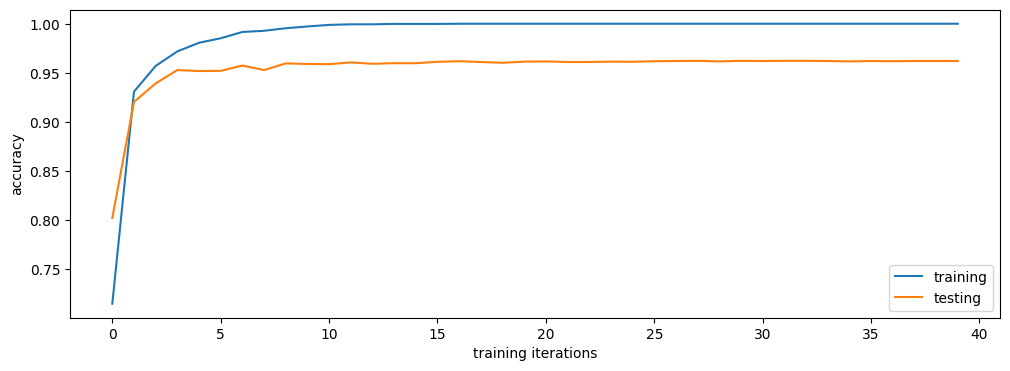

In [22]:
# **3. d) [2 marks]** Now we will add a convolution layer to our network.  The following network adds two convolution layers before two normal neural network layers.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)  # set the size of the convolution to 5x5, and have 12 of them
        self.conv2 = nn.Conv2d(12, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # make sure to do max pooling after the convolution layers
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

# The following code can be used to plot the learned features in the first layer:

plt.figure(figsize=(12,5))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(network.conv1.weight[i][0].detach().numpy(), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()

# - Train the model through 40 iterations and generate a plot of training and testing accuracy over time.

network = Net()
optimizer = optim.SGD(network.parameters(), 
                      lr=0.1,
                      momentum=0.5)

accuracy_train = []
accuracy_test = []

for i in range(40):
    continue_training()

# plot
plt.figure(figsize=(12,4))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()


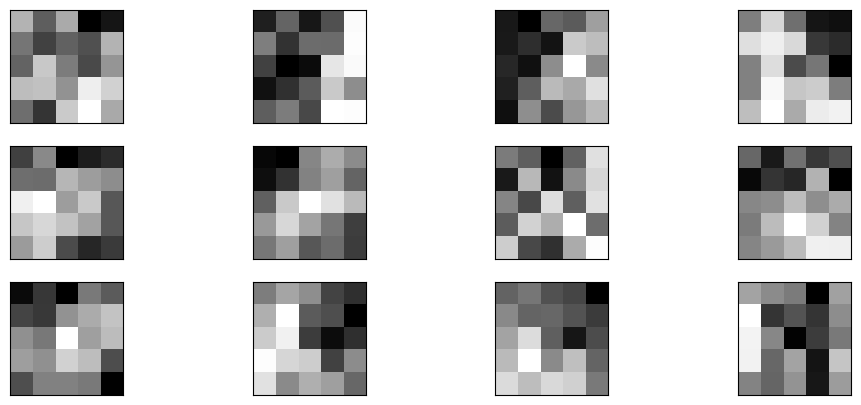

In [26]:
# - Plot the features learned by the first convolution layer.  How do they compare to real features detected in the V1 area of the brain?

plt.figure(figsize=(12,5))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(network.conv1.weight[i][0].detach().numpy(), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()

**BONUS [1 mark]** Try to improve the neural network.  You want to get the best testing accuracy you can.  Try at least two different approaches and report your results.